<a href="https://colab.research.google.com/github/karthik1338/geeksforgeeks/blob/main/day_2_netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Go to Submission section Down for assignment

#Step 1: Setup - Importing Libraries

pandas, numpy, matplotlib.pyplot, seaborn , worldcloud


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set a consistent style for our plots
sns.set_style('darkgrid')

#Step 2: Data loading and Initial Inspection

load netflix_titles.csv datasets


In [62]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.


In [63]:
netflix_df = pd.read_csv("/content/21-Days-21-Projects-Dataset/Datasets/netflix_titles.csv")
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [64]:
#Get a concise summary of the dataframe
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


#Summary:
- we have 7787 entries
- key Problem:
    - The data_added -> object(string) not datatime formate for analysis.
- missing values:
  - director, cast, country, date_added, rating.
  - director has the most missing values.

#Step 3: Data cleaning and tranformation
- handle missing values
- correct the data-type / data formate


In [65]:
# 1. Hnadling missing values in 'diractor' and 'cast'
# we can fill 'Unknown' as missing values because type is string
netflix_df[['director', 'cast']] = netflix_df[['director', 'cast']].fillna('Unknown')


In [66]:
# 2. handling missing 'country'
# we will fill mode, which is the most common country.
mode_country = netflix_df['country'].mode()[0]
netflix_df['country'] = netflix_df['country'].fillna(mode_country)


In [67]:
# 3. Drop the few rows with missing 'date_added' and 'rating'
# since they are unique and are in small (less than 0.2% of data ), droping them is the safe options
netflix_df.dropna(subset=['date_added', 'rating'], inplace=True)

In [68]:
# 4. convert 'date_added' to datetime object
# use formate = "mixed" to handle potential variations in data formats
# dayfirst = false means first is month 01/02/2025 -> 02 jan 2025
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], format='mixed', dayfirst=False)

In [69]:
# 5. Create a new feature for year and month added
# dt.year -> year, dt.month -> month
netflix_df['year_added'] = netflix_df['date_added'].dt.year
netflix_df['month_added'] = netflix_df['date_added'].dt.month

In [70]:
#verify the cleaning and transformation
print("Missing values after cleaning:")
print(netflix_df.isnull().sum())
print("\nData types after cleaning:")
print(netflix_df.dtypes)

Missing values after cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
year_added      0
month_added     0
dtype: int64

Data types after cleaning:
show_id                 object
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
year_added               int32
month_added              int32
dtype: object


#Step 4: Exploratory Data Analysis & Visulation
#4.1 What is the distribition content type?

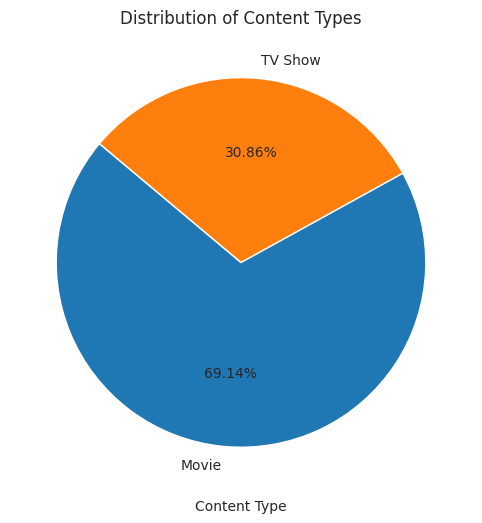

In [71]:
plt.figure(figsize=(8, 6))
type_counts = netflix_df['type'].value_counts()
plt.pie(type_counts, labels = type_counts.index, autopct='%1.2f%%', startangle=140 )
plt.title('Distribution of Content Types')
plt.xlabel('Content Type')
plt.show()

**Insight**

The netflix library is dominated by movies, which makes up roughly 70% of the content in dataset.

# 4.2 How has content been added over time?

<Figure size 1200x600 with 0 Axes>

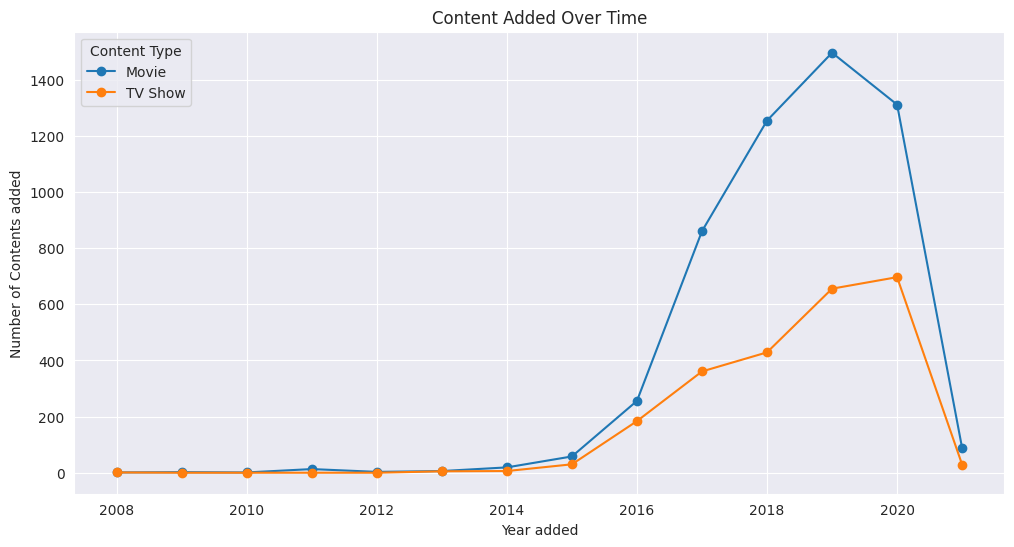

In [72]:
# Group data by year and content type
content_over_time = netflix_df.groupby(['year_added', 'type']).size().unstack(fill_value=0)

# Plot the data
plt.figure(figsize=(12, 6))
content_over_time.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Content Added Over Time')
plt.xlabel('Year added')
plt.ylabel('Number of Contents added')
plt.legend(title='Content Type')
plt.grid(True)
plt.show()

**Insight:**

this is the movie and tv show added over the time. we can observe that the both are being added steadly and we can also see the drop in the year 2020 - 2021 may be due to covid-19.


In [73]:
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,12
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017,11
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,1


#4.3 What are the most popuar genres?
#### **Theoretical Concept: Handling Multi-Value Text Columns**
The `listed_in` column contains strings with multiple genres separated by commas (e.g., "Dramas, International Movies"). To analyze each genre individually, we need to transform the data. A common technique is to:
1.  **Split** the string in each row into a list of genres.
2.  **Explode** the DataFrame so that each genre in the list gets its own row, duplicating the other information for that title.
This allows us to perform a `value_counts()` on the genres.

In [74]:
# Split the 'listed_in' column and explode it
genres = netflix_df.assign(genre = netflix_df['listed_in'].str.split(',')).explode('genre')


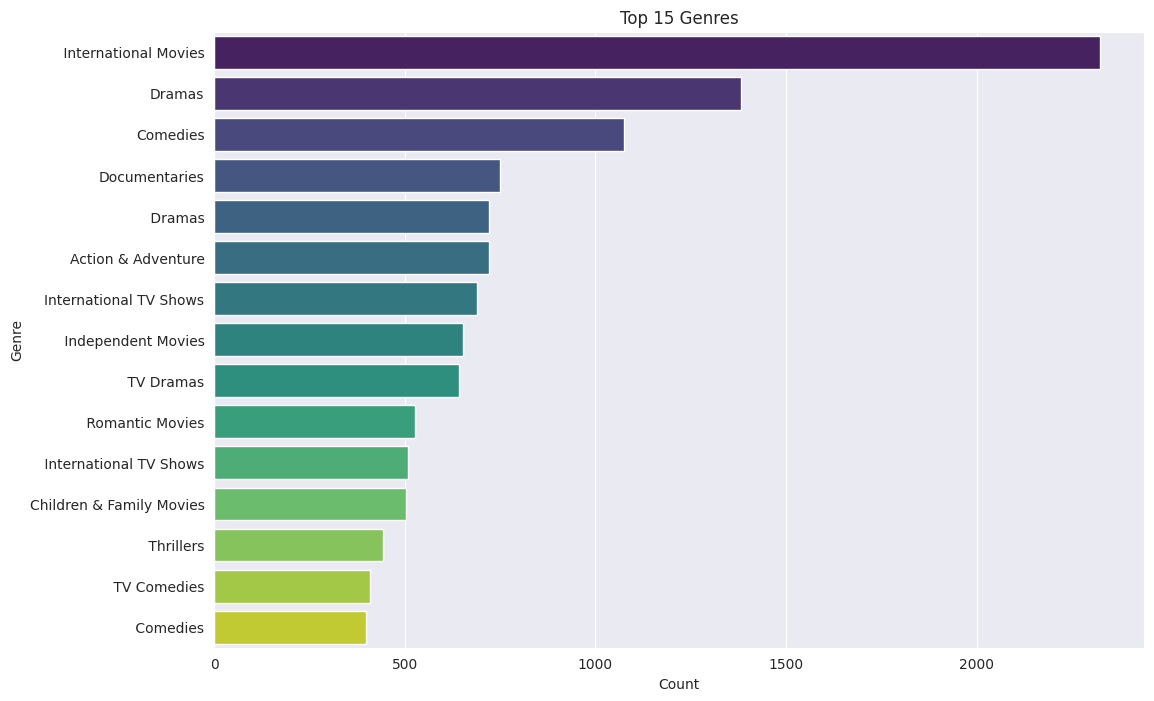

In [75]:
# Get the top 15 generes and their counts
top_genres_counts = genres['genre'].value_counts().reset_index()
top_genres_counts.columns = ['genre', 'count'] # Rename columns for clarity

#Select only the top 15 for ploting
top_genres_counts = top_genres_counts.head(15)

# Create a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(y='genre', x='count', data=top_genres_counts, palette='viridis', hue='genre', legend=False)
plt.title('Top 15 Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

**Insight:**

'International Movies' is the most common genere tag, highlighting Netflix's gobal content strategy.. This is followed ny Dramas, Comedies and Action & Adventure.

# 4.4 What is the Distribution of content duration

In [76]:
# Seperate movie and TV Shows
movie_df = netflix_df[netflix_df['type'] == 'Movie'].copy()
tv_show_df = netflix_df[netflix_df['type'] == 'TV Show'].copy()

In [77]:
# Clean and convert duration for movie
movie_df['duration'] = movie_df['duration'].str.replace(' min', '').astype(int )

#clean and conver duration for tv show
tv_show_df['duration'] = tv_show_df['duration'].str.replace(' Seasons', '').str.replace(' Season', '').astype(int)


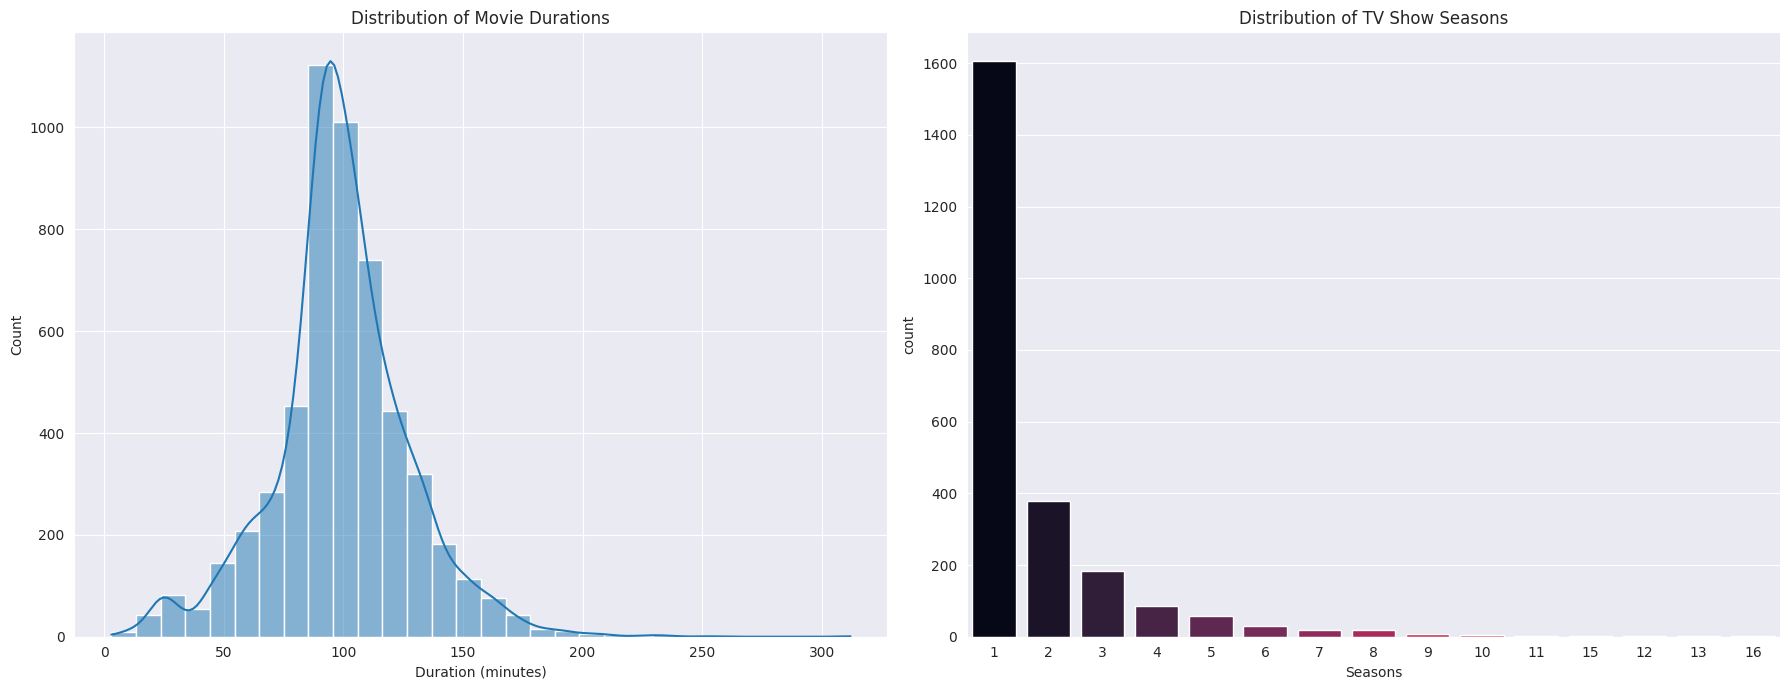

In [78]:
# Plot the distributions
fig , axis = plt.subplots(1, 2, figsize=(18, 7))

# Movie Duration Distribution
sns.histplot(movie_df['duration'], bins=30, kde=True, ax=axis[0])
axis[0].set_title('Distribution of Movie Durations')
axis[0].set_xlabel('Duration (minutes)')

# TV Show Season Distribution
sns.countplot(ax=axis[1], x='duration', data=tv_show_df, palette='rocket', order=tv_show_df['duration'].value_counts().index, hue='duration', legend=False)
axis[1].set_title('Distribution of TV Show Seasons')
axis[1].set_xlabel('Seasons')

plt.tight_layout()
plt.show()

**Insight:**
- The majority of movies on Netflix are between 80 and 120 minutes long, which is standard for feature films.
- The vast majority of TV shows on Netflix are short-lived, with most having only 1 season. This could reflect a strategy of producing many pilots and only renewing the most successful ones, or a focus on limited series.

# 4.5 Where does the content come from? (Geographical Analysis)

In [79]:
# Handle multi-country listing similar to genres
contries = netflix_df.assign(country = netflix_df['country'].str.split(', ')).explode('country')

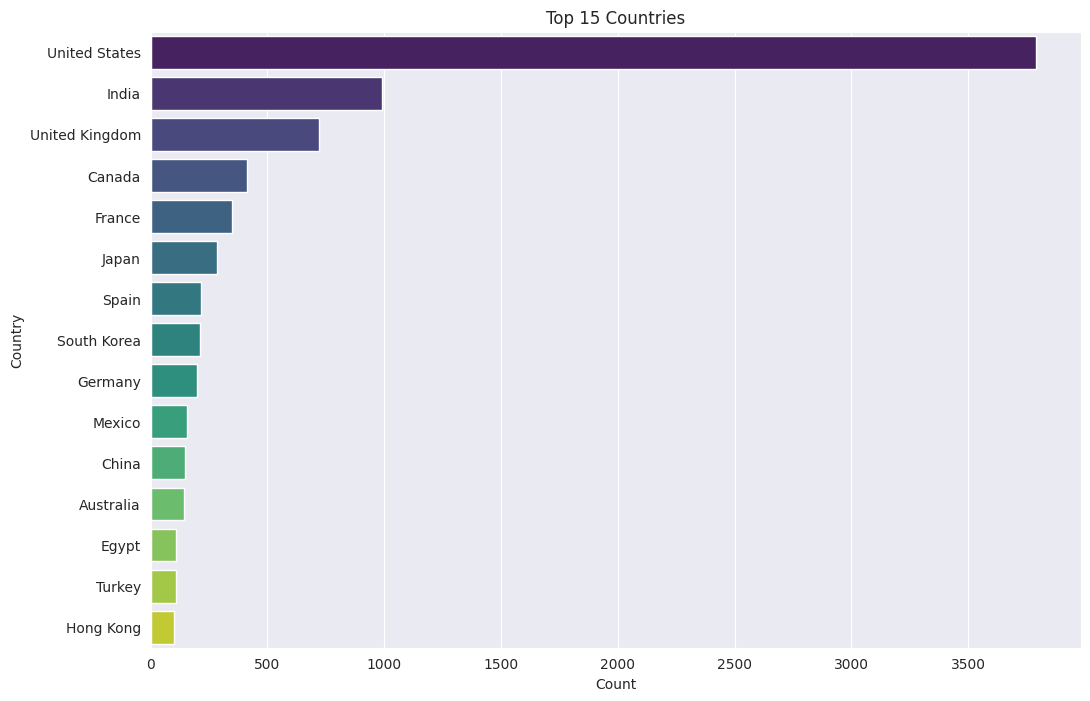

In [80]:
# Get the top 15 countries and their counts
top_countries_counts = contries['country'].value_counts().reset_index()
top_countries_counts.columns = ['country', 'count'] # Rename columns for clarity

#Select only the top 15 for ploting
top_countries_counts_plot = top_countries_counts.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y='country', x='count', data=top_countries_counts_plot, palette='viridis', hue='country', legend=False)
plt.title('Top 15 Countries')
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()

**Insight:**

United States is by far the largest producer of content avilable on Netflix. However, India is a very strong second, and other like UK, Japan and South Korea also represent major content markets for the platform, emphasizing its global nature.

In [81]:
netflix_df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12


# 4.6 What are the mautrity rating of the content?

/tmp/ipython-input-1896956935.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=netflix_df, x='rating',order = rating_counts, palette='viridis')


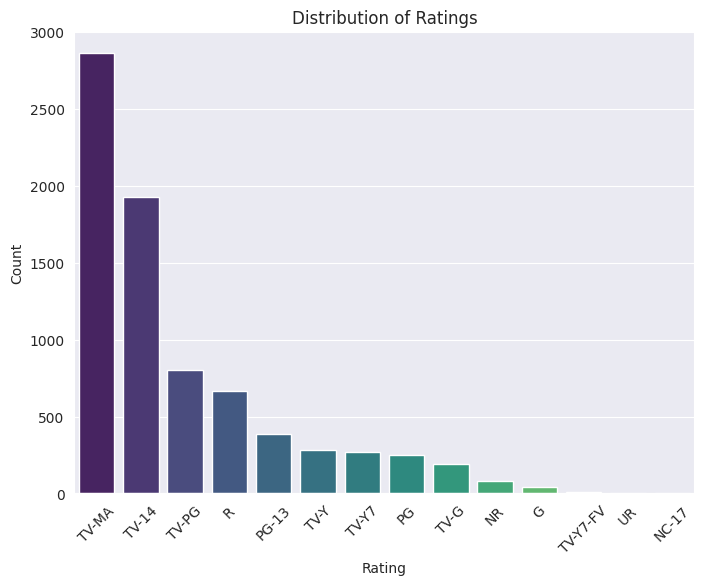

In [82]:
plt.figure(figsize=(8, 6))
rating_counts = netflix_df['rating'].value_counts().index
sns.countplot(data=netflix_df, x='rating',order = rating_counts, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Insight:**

Based on the distribution of ratings, the majority of content on Netflix is rated TV-MA and TV-14, indicating a focus on mature and teenage audiences. There is also a significant amount of content rated R and PG-13, suggesting a broad range of movies and TV shows for different age groups.

#Step 5: Feature Engineering  - Content Freahness

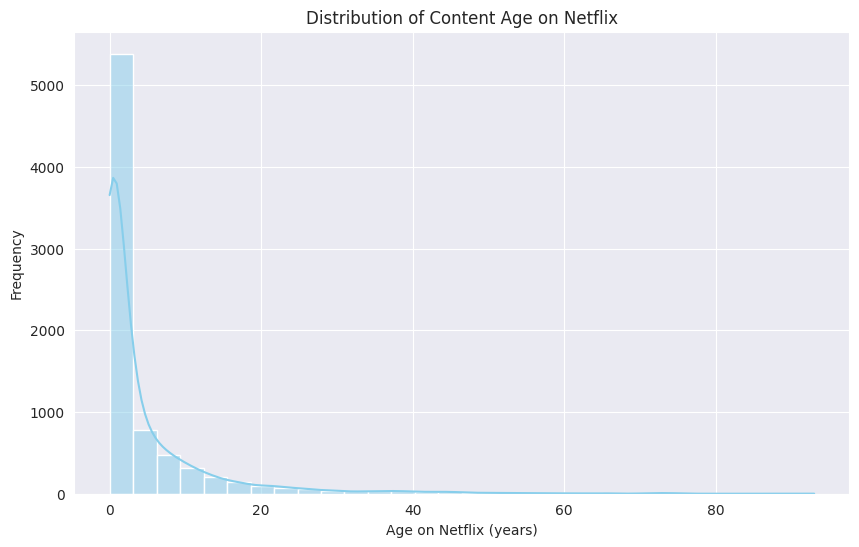

In [83]:
# Creaate the 'age_on_netflix' feature
netflix_df['age_on_netflix'] = netflix_df['year_added'] - netflix_df['release_year']

# filter out the potential error where added_year is before release_year
content_age = netflix_df[netflix_df['age_on_netflix'] >= 0]

plt.figure(figsize=(10, 6))
sns.histplot(content_age['age_on_netflix'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Content Age on Netflix')
plt.xlabel('Age on Netflix (years)')
plt.ylabel('Frequency')
plt.show()


**Insight:**

The distribution of content age on Netflix shows a peak around 0-5 years, indicating that a significant portion of the content added is relatively recent. There is a long tail to the distribution, suggesting that Netflix also includes older content, but the focus appears to be on acquiring and adding newer titles.

#Step 6: Deeper Multivariante Analysis

In [84]:
genres.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,genre
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8,International TV Shows
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8,TV Dramas


In [85]:
top_genres = genres['genre'].value_counts().head(10).index[:5]
genres_movies = genres[(genres['type'] == 'Movie') & (genres['genre'].isin(top_genres))].copy()
genres_movies['duration_min'] = genres_movies['duration'].str.replace(' min', '').astype(int)


In [86]:
genres_movies

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,genre,duration_min
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12,Dramas,93
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12,International Movies,93
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,12,International Movies,78
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,1,Dramas,123
6,s7,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,2020-06-01,2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ...",2020,6,International Movies,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7783,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,2019-03-02,2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,2019,3,Dramas,111
7783,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,2019-03-02,2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,2019,3,International Movies,111
7784,s7785,Movie,Zulu Man in Japan,Unknown,Nasty C,United States,2020-09-25,2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast...",2020,9,Documentaries,44
7784,s7785,Movie,Zulu Man in Japan,Unknown,Nasty C,United States,2020-09-25,2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast...",2020,9,International Movies,44


/tmp/ipython-input-3046216799.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genre', y='duration_min', data=genres_movies, palette='viridis')


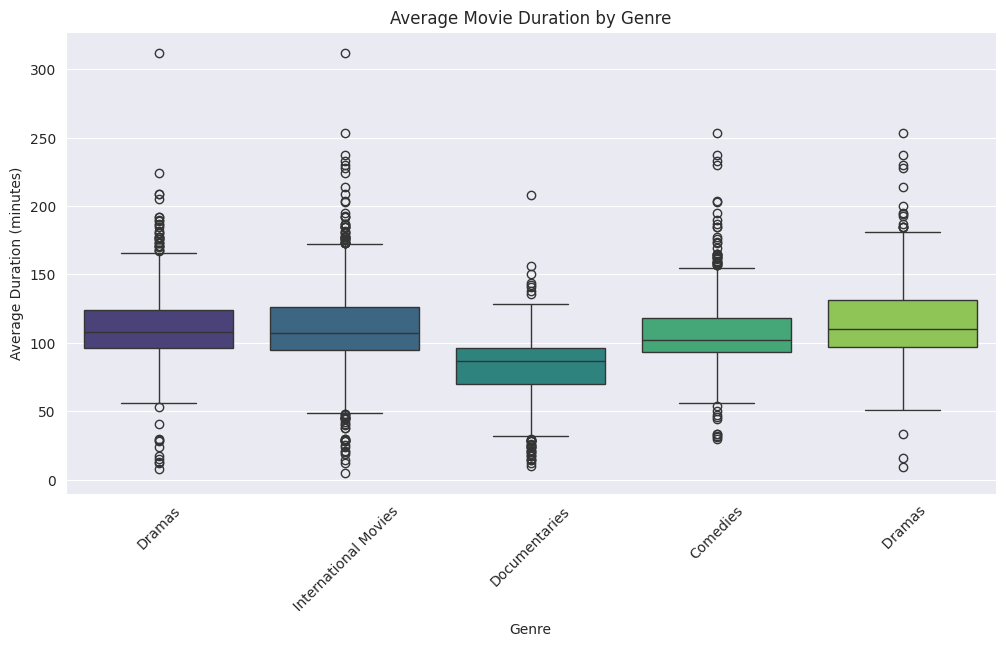

In [87]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='duration_min', data=genres_movies, palette='viridis')
plt.title('Average Movie Duration by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Duration (minutes)')
plt.xticks(rotation=45)
plt.show()

**Insight:**

Looking at the boxplot of movie durations by genre, we can observe some variations. While most popular genres like Dramas, Comedies, and International Movies have a similar median duration, Documentaries tend to have a shorter average duration. This suggests that genre can play a role in the typical length of a movie on Netflix.

#Step 7: Word cloud from Content Descriptions

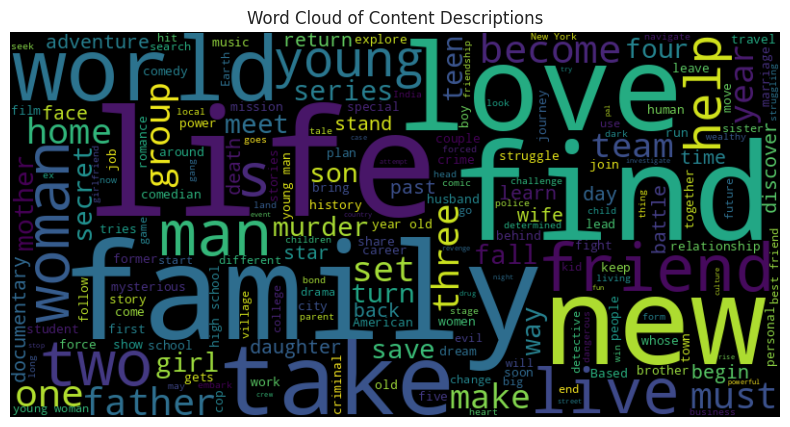

In [88]:
# Combine all descriptins into a single string
text = ' '.join(netflix_df['description'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Display the genetated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Content Descriptions')
plt.show()

**Insight:**

The word cloud of content descriptions highlights the most frequently used words in the summaries of Netflix titles. Prominent words like "story," "life," "world," "family," and "young" suggest common themes and subject matter across the platform's content library.

#Step 8: Final conclusion and summary of Insights


# Final Conclusion and Summary of Insights

This analysis of the Netflix dataset revealed several key insights about the platform's content library:

1.  **Content Distribution:** Movies significantly outnumber TV Shows on Netflix, making up the majority of the content.
2.  **Content Growth Over Time:** Both movies and TV shows have been added to the platform steadily over the years, with a noticeable increase in recent years (though a slight dip around 2020-2021, potentially related to global events like the COVID-19 pandemic).
3.  **Popular Genres:** "International Movies" is the most prevalent genre tag, highlighting Netflix's global content strategy. Dramas, Comedies, and Action & Adventure are also very popular.
4.  **Content Duration:** Movies typically fall within the 80-120 minute range, while most TV shows are limited to a single season.
5.  **Geographical Distribution:** The United States is the primary source of content, with India being a strong second. Other significant content providers include the UK, Japan, and South Korea.
6.  **Maturity Ratings:** The platform heavily features content for mature and teenage audiences (TV-MA, TV-14), with a good selection of R and PG-13 rated titles as well.
7.  **Content Freshness:** A large portion of the content added to Netflix is relatively recent (within the last 0-5 years), indicating a focus on newer releases, while still maintaining a back catalog of older titles.
8.  **Genre and Duration Relationship:** While most popular movie genres have similar durations, Documentaries tend to be shorter.
9.  **Common Themes:** Analysis of content descriptions shows recurring themes around "story," "life," "world," "family," and "young."

Overall, the Netflix content library is diverse, with a strong emphasis on movies, international content, and a wide range of genres and maturity ratings to cater to a global audience. The platform actively adds newer content while maintaining a substantial collection of older titles.

**Next Steps:**

*   Explore specific genres or countries in more detail.
*   Analyze cast and director popularity.
*   Examine trends in release year vs. added year.
*   Build recommendation systems based on genre, cast, director, or description.

# Day 2: Submission

* How has the distribution of content ratings changed over time?
* Is there a relationship between content age and its type (Movie vs. TV Show)?
* Can we identify any trends in content production based on the release year vs. the year added to Netflix?
* What are the most common word pairs or phrases in content descriptions?
* Who are the top directors on Netflix?

In [89]:
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,age_on_netflix
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8,0
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12,0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,12,7
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017,11,8
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,1,12


#1. How has the distribution of content ratings changed over time?

/tmp/ipython-input-2242738707.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=netflix_df,x = netflix_df['rating'], y = netflix_df['year_added'], palette='viridis')
/tmp/ipython-input-2242738707.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Rating')


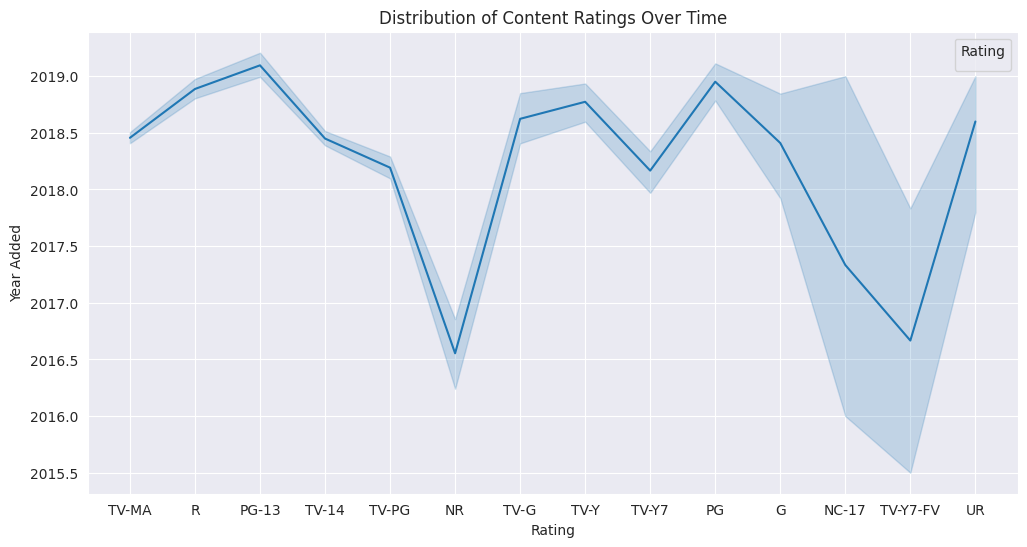

In [90]:
# How has the distribution of content ratings changed over time?
plt.figure(figsize=(12, 6))
sns.lineplot(data=netflix_df,x = netflix_df['rating'], y = netflix_df['year_added'], palette='viridis')
plt.title('Distribution of Content Ratings Over Time')
plt.ylabel('Year Added')
plt.xlabel('Rating')
plt.legend(title='Rating')
plt.show()

<Figure size 1500x800 with 0 Axes>

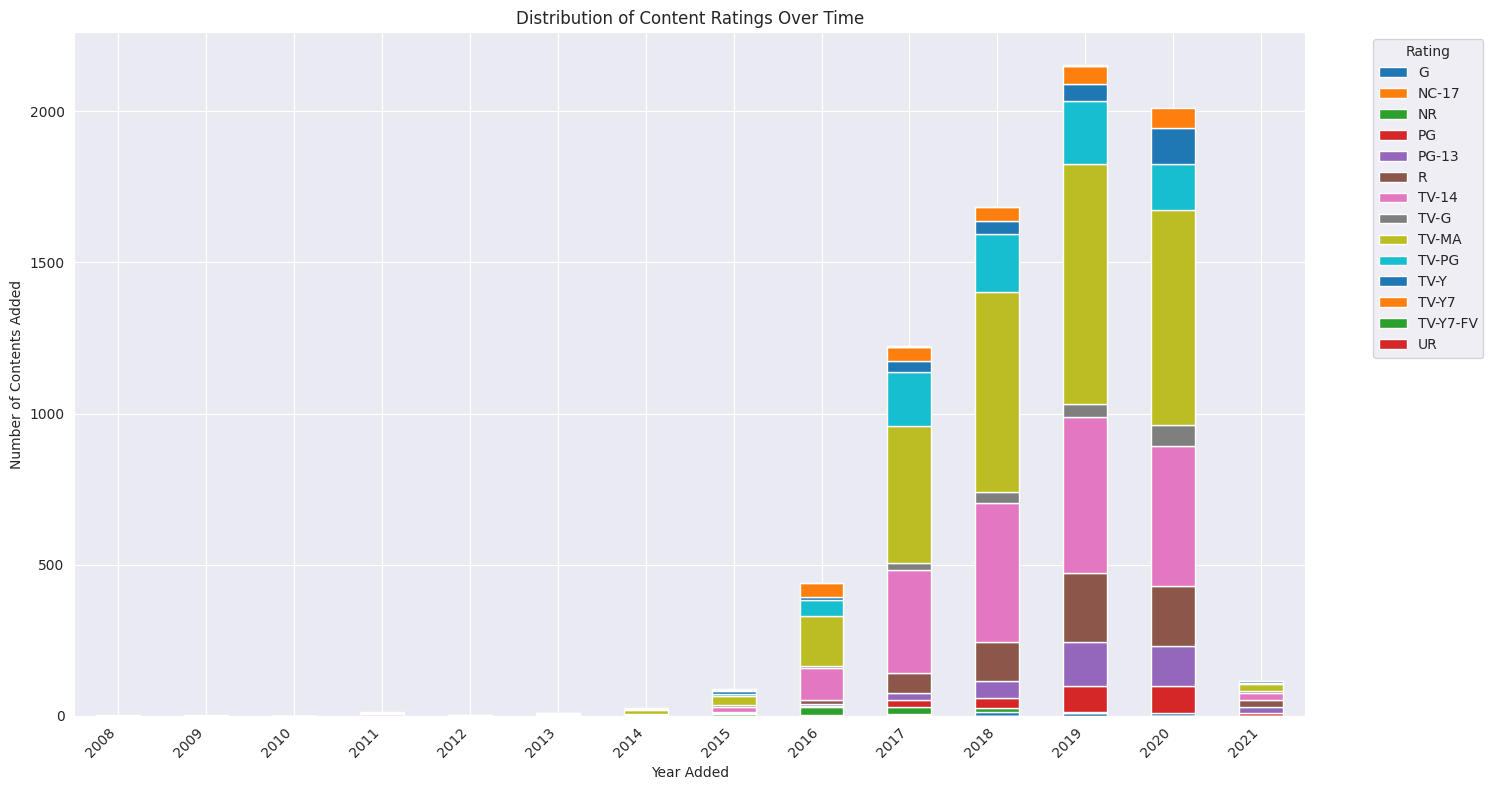

In [91]:
# Group and count ratings by year
rating_over_time = netflix_df.groupby(['year_added', 'rating']).size().unstack(fill_value=0)

# Plot the data as a stacked bar chart
plt.figure(figsize=(15, 8))
rating_over_time.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Distribution of Content Ratings Over Time')
plt.xlabel('Year Added')
plt.ylabel('Number of Contents Added')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Insight:**

The stacked bar chart clearly illustrates a significant increase in the overall volume of content added to Netflix each year, especially from around 2016 onwards. We can also observe that while a wide range of ratings are present, the proportion of content rated TV-MA and TV-14 has consistently been high, particularly in recent years, reinforcing the platform's focus on mature and teenage audiences. There also appears to be growth in other ratings like R and PG-13 over time.

#2. Is there a relationship between content age and its type (Movie vs. TV Show)?


/tmp/ipython-input-1506339737.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = netflix_df['age_on_netflix'], x = netflix_df['type'], palette='viridis')


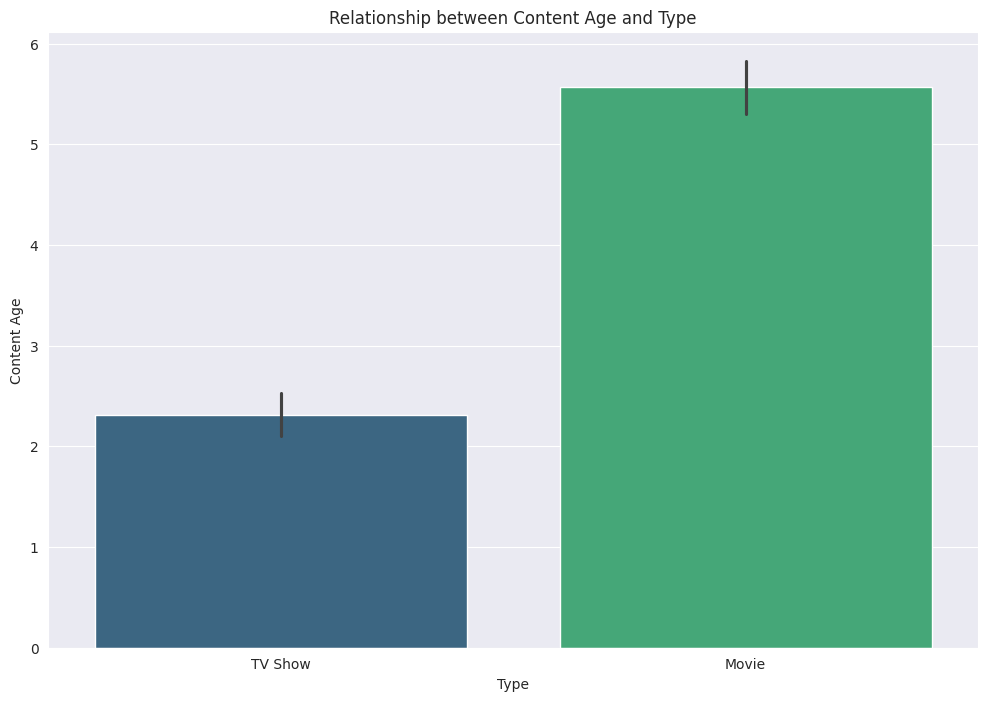

In [92]:
# relationship between content age and type
plt.figure(figsize=(12,8))
sns.barplot(y = netflix_df['age_on_netflix'], x = netflix_df['type'], palette='viridis')
plt.title('Relationship between Content Age and Type')
plt.ylabel('Content Age')
plt.xlabel('Type')
plt.show()


**Insight:**

The bar plot shows that on average, movies added to Netflix tend to be older than TV shows. This suggests that Netflix acquires older movies for its library while focusing on adding newer TV series, possibly including original productions.

#3. Can we identify any trends in content production based on the release year vs. the year added to Netflix?

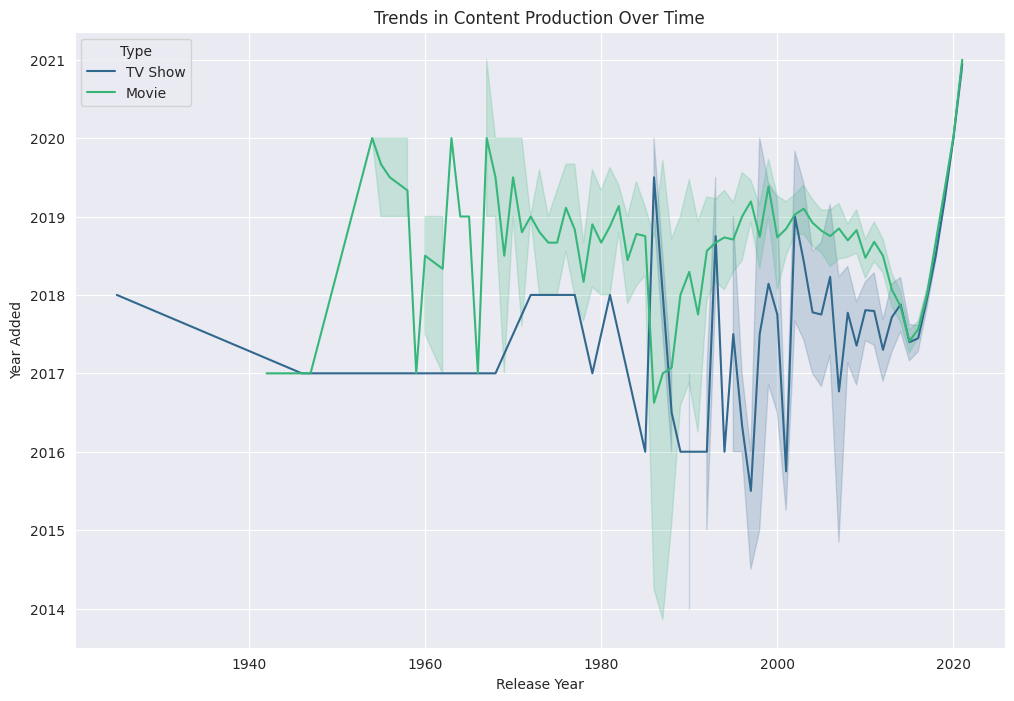

In [93]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=netflix_df, x='release_year', y='year_added', hue='type', palette='viridis')
plt.title('Trends in Content Production Over Time')
plt.xlabel('Release Year')
plt.ylabel('Year Added')
plt.legend(title='Type')
plt.show()

**Insight**

The line plot shows that for both movies and TV shows, content with more recent release years is generally added to Netflix in more recent years. This indicates that Netflix is actively acquiring and adding newer content to its library. We can also observe that there's a range of release years for content added in any given year, suggesting that Netflix also adds older titles. The lines for movies and TV shows show a similar trend, indicating that this pattern holds true for both types of content.

#4. What are the most common word pairs or phrases in content descriptions?

In [94]:
# remove non_alphabet in text
text1 = [''.join(char for char in s if char.isalpha() or char.isspace()) for s in netflix_df['description']]
text1 = ' '.join(text1)



In [95]:
des = text1.split()
n = int(input())
cloud_text = ''
for i in range(len(des)-n+1):
  for j in range(n):
    cloud_text += des[i+j] + '_'
  cloud_text += ' '

3


In [107]:
#Sample world
sample = cloud_text.split()
for i in range(10):
  print(sample[i])

In_a_future_
a_future_where_
future_where_the_
where_the_elite_
the_elite_inhabit_
elite_inhabit_an_
inhabit_an_island_
an_island_paradise_
island_paradise_far_
paradise_far_from_


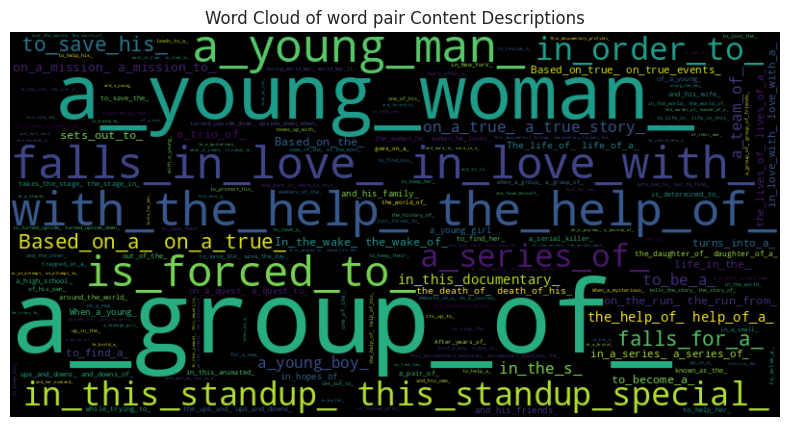

In [106]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(cloud_text)

# Display the genetated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of word pair Content Descriptions')
plt.show()

**Insight**

The word cloud visually represents the most frequent two-word phrases ("word pairs") from a collection of content descriptions. The larger the text, the more frequently that word pair appeared, highlighting dominant linguistic structures like "in the," "and the," and "when the." The presence of phrases such as "a young man," "falls in love," and "after his" suggests a narrative or story-centric focus in the source material. While it reveals common sentence components and hints at descriptive content, the word cloud primarily showcases language patterns rather than specific subject matter, as common grammatical elements are often the most prominent.

#5. Who are the top directors on Netflix?

In [98]:
netflix_df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,age_on_netflix
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8,0
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12,0


In [99]:
# Get the top 15 director and their counts
top_director_counts = netflix_df['director'].value_counts().reset_index()
top_director_counts.columns = ['director', 'count'] # Rename columns for clarity

#Select only the top 15 for ploting
top_director_counts_plot = top_director_counts.head(15)

top_director_counts_plot



,director,count
0,Unknown,2376
1,"Raúl Campos, Jan Suter",18
2,Marcus Raboy,16
3,Jay Karas,14
4,Cathy Garcia-Molina,13
5,Martin Scorsese,12
6,Youssef Chahine,12
7,Jay Chapman,12
8,Steven Spielberg,10
9,David Dhawan,9


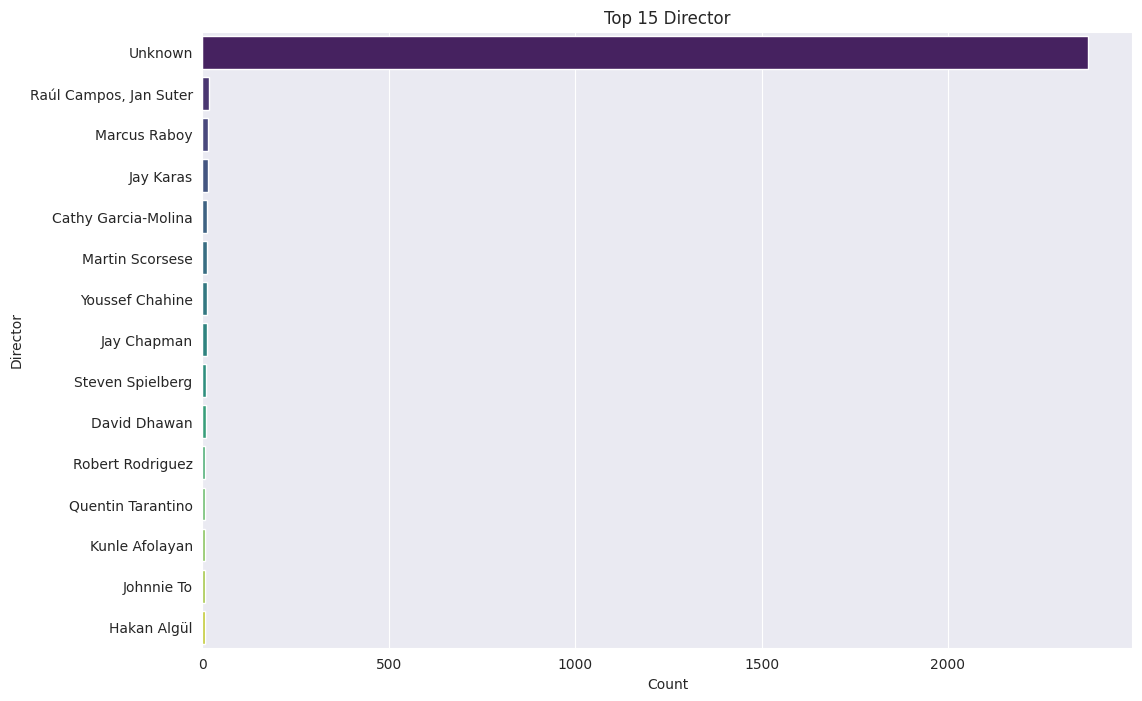

In [100]:
plt.figure(figsize=(12, 8))
sns.barplot(y='director', x='count', data=top_director_counts_plot, palette='viridis', hue='director', legend=False)
plt.title('Top 15 Director')
plt.xlabel('Count')
plt.ylabel('Director')
plt.show()

In [101]:
# removing the "Unknown" because it is a anomoly
top_director_counts.drop(index=top_director_counts.index[0], inplace=True)
top_director_counts_plot = top_director_counts.head(15)
top_director_counts_plot

,director,count
1,"Raúl Campos, Jan Suter",18
2,Marcus Raboy,16
3,Jay Karas,14
4,Cathy Garcia-Molina,13
5,Martin Scorsese,12
6,Youssef Chahine,12
7,Jay Chapman,12
8,Steven Spielberg,10
9,David Dhawan,9
10,Robert Rodriguez,8


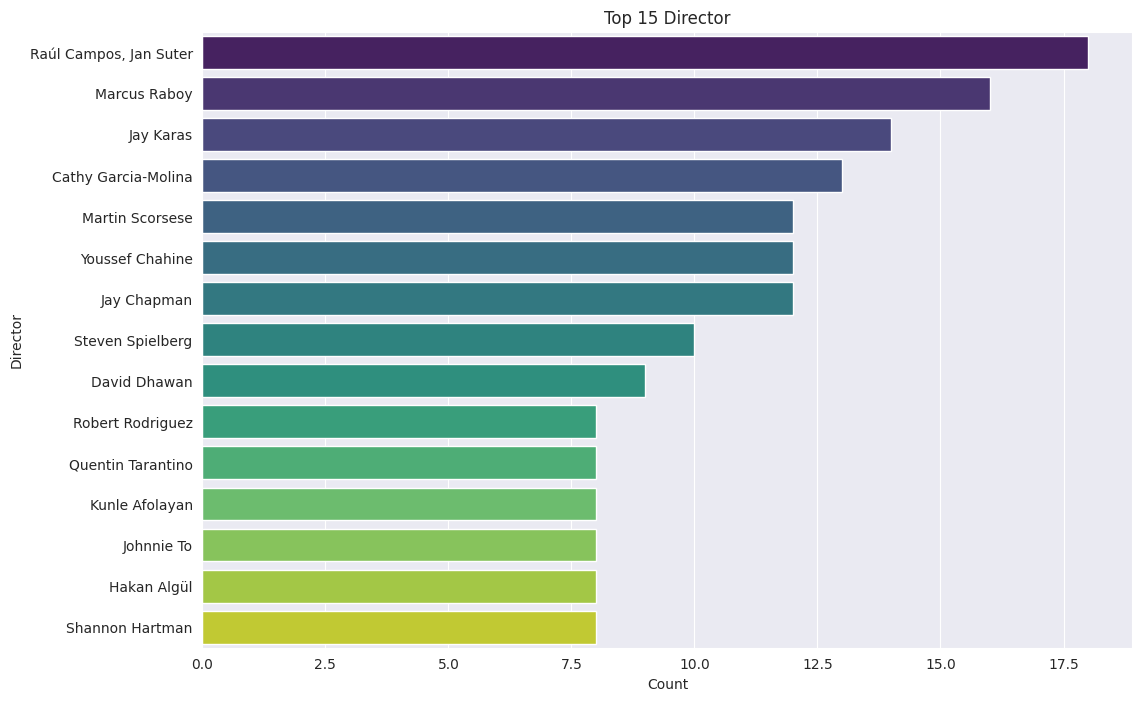

In [102]:
plt.figure(figsize=(12, 8))
sns.barplot(y='director', x='count', data=top_director_counts_plot, palette='viridis', hue='director', legend=False)
plt.title('Top 15 Director')
plt.xlabel('Count')
plt.ylabel('Director')
plt.show()

**Insight:**

After removing the "Unknown" category, the bar chart of the top 15 directors reveals some interesting trends. While there are directors with a significant number of titles like Raúl Campos and Jan Suter, and Marcus Raboy, who likely direct many stand-up specials or similar short-form content, we also see prominent feature film directors such as Martin Scorsese, Steven Spielberg, and Quentin Tarantino. This indicates that Netflix features content from both prolific directors who work across various formats and highly acclaimed directors known for their feature films. The presence of directors like Cathy Garcia-Molina and Youssef Chahine also points to the platform's inclusion of international directorial talent.